In [1]:
# Import Dependencies
%matplotlib inline
import itertools

# Start Python Imports
import math, time, random, datetime
import pickle # or `import dill as pickle`, if you're using the dill package
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv


from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics


from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)


%matplotlib inline


In [2]:
train_store = pd.read_csv('/home/david/Desktop/Rossmann-Store-Sales/train_store.csv')

In [3]:
train_store.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1             0   
1      1          4  2015-07-30   5020        546     1      1             0   
2      1          3  2015-07-29   4782        523     1      1             0   
3      1          2  2015-07-28   5011        560     1      1             0   
4      1          1  2015-07-27   6102        612     1      1             0   

   SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
0              1          3           1               1270.0   
1              1          3           1               1270.0   
2              1          3           1               1270.0   
3              1          3           1               1270.0   
4              1          3           1               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear  PromoInterval  
0              0.0              0.0              0  
1              0.0              0.0              0  
2              0.0              0.0              0  
3              0.0              0.0              0  
4              0.0              0.0              0


To get more information about a new modules you have imported, run the cell below. A window containing a description of the module will appear! This provides details on the module parameters and attributes and links for further references. Try it out!

In [4]:
print(train_store.columns[0:120])

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')


In [5]:
test = pd.read_csv('/home/david/Desktop/Rossmann-Store-Sales/test.csv')

In [6]:
test.head()

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0
2   3      7          4  2015-09-17   1.0      1            0              0
3   4      8          4  2015-09-17   1.0      1            0              0
4   5      9          4  2015-09-17   1.0      1            0              0

## Checking features for Multicollinearity
Before we get run our model, let's make sure we are not including unnecessary features. A great way to do this is using a correlation plot, because for both linear regression and decision trees we do not want to include correlated features.

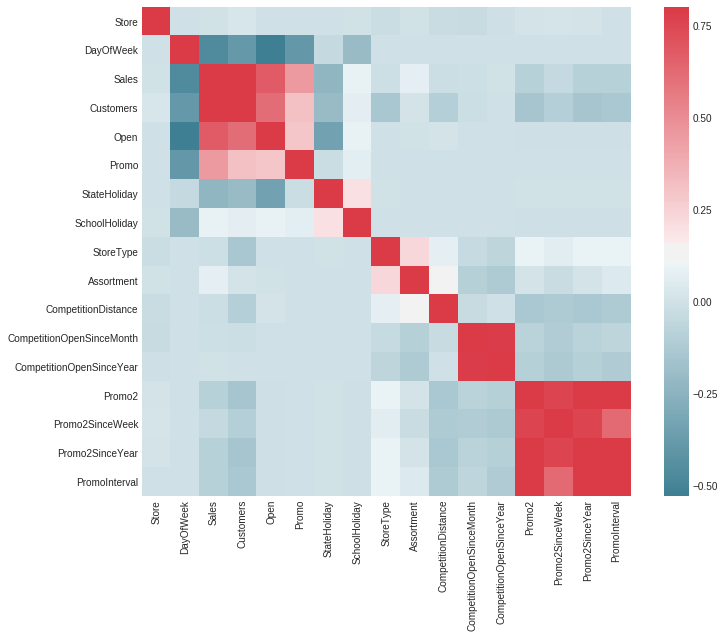

In [7]:
# Compute the correlation matrix
corrmat  = train_store.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap using seaborn
sns.heatmap(corrmat, cmap=cmap, vmax=.8, square=True)

## When we build a correlation plot we are are checking for multicollinearity!
The plot above is a way to check for multicollinearity. Multicollinearity is a problem when we have highly correlated explanatory features, as this makes it difficult for the model to try to differentitae between each feature's influence on the explanatory feature.

In the code below, instead of plotting the correlation matrix, we filter to only the top abs correlations that are not one. This will help us isolate the interactions that are most problematic.

In [8]:
# def get_redundant_pairs(df):
#     '''Get diagonal and lower triangular pairs of correlation matrix'''
#     pairs_to_drop = set()
#     cols = df.columns
#     for i in range(0, df.shape[1]):
#         for j in range(0, i+1):
#             pairs_to_drop.add((cols[i], cols[j]))
#     return pairs_to_drop

# def get_top_abs_correlations(df, n=5):
#     au_corr = df.corr().abs().unstack()
#     labels_to_drop = get_redundant_pairs(df)
#     au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
#     return au_corr[0:n]

# print("Top Absolute Correlations")
# print(get_top_abs_correlations(train_store, 20))

In [9]:
del train_store['Promo2SinceYear']

In [10]:
new_df= train_store

In [11]:
new_df.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1             0   
1      1          4  2015-07-30   5020        546     1      1             0   
2      1          3  2015-07-29   4782        523     1      1             0   
3      1          2  2015-07-28   5011        560     1      1             0   
4      1          1  2015-07-27   6102        612     1      1             0   

   SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
0              1          3           1               1270.0   
1              1          3           1               1270.0   
2              1          3           1               1270.0   
3              1          3           1               1270.0   
4              1          3           1               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  PromoInterval  
0              0.0              0  
1              0.0              0  
2              0.0              0  
3              0.0              0  
4              0.0              0

In [12]:
new_df['year'] = pd.DatetimeIndex(new_df['Date']).year
new_df['month'] = pd.DatetimeIndex(new_df['Date']).month
new_df['day'] = pd.DatetimeIndex(new_df['Date']).day
new_df['week'] = pd.DatetimeIndex(new_df['Date']).week
#train_store['dayofweek'] = pd.DatetimeIndex(train_store['Date']).dayofweek




new_df.tail()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
1017204   1115          6  2013-01-05   4771        339     1      0   
1017205   1115          5  2013-01-04   4540        326     1      0   
1017206   1115          4  2013-01-03   4297        300     1      0   
1017207   1115          3  2013-01-02   3697        305     1      0   
1017208   1115          2  2013-01-01      0          0     0      0   

         StateHoliday  SchoolHoliday  StoreType  ...   CompetitionDistance  \
1017204             0              1          4  ...                5350.0   
1017205             0              1          4  ...                5350.0   
1017206             0              1          4  ...                5350.0   
1017207             0              1          4  ...                5350.0   
1017208             1              1          4  ...                5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1017204                        0.0                       0.0       1   
1017205                        0.0                       0.0       1   
1017206                        0.0                       0.0       1   
1017207                        0.0                       0.0       1   
1017208                        0.0                       0.0       1   

         Promo2SinceWeek  PromoInterval  year  month  day  week  
1017204             22.0              3  2013      1    5     1  
1017205             22.0              3  2013      1    4     1  
1017206             22.0              3  2013      1    3     1  
1017207             22.0              3  2013      1    2     1  
1017208             22.0              3  2013      1    1     1  

[5 rows x 21 columns]

In [13]:
del new_df['Date']


# Splitting into train and test¶

## X_train, y_train, X_test, y_test

In [14]:
print(new_df.columns)

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'PromoInterval', 'year', 'month', 'day', 'week'],
      dtype='object')


In [15]:
train, test = train_test_split(new_df, test_size=0.2, random_state=42)
len(train)
len(test)

203442

In [16]:
len(train)

813767

In [17]:

# create a training array = all the features but not the target and a training test array = the results of the target variable for the training array
new_dfY = new_df['Sales']
new_dfX = new_df.drop('Sales', axis=1)

In [18]:

X_train, X_test, y_train, y_test = train_test_split(new_dfX, new_dfY, test_size=0.3, random_state=42)

len(X_train)
len(X_test)
len(y_train)
len(y_test)

305163

In [19]:
len(X_test)


305163

In [20]:
len(y_train)


712046

In [21]:
len(y_test)

305163

In [22]:
len(y_train)

712046

# Decision Tree and Random Forest

In [23]:
#Date=new_df['Date']


#date_df=pd.DataFrame({"year": Date.dt.year,
 #             "month": Date.dt.month,
  #            "day": Date.dt.day,
              #"hour": Date.dt.hour,
              #"dayofyear": Date.dt.dayofyear,
   #                  "Date":Date.dt.date,
    #          "week": Date.dt.week,
              #"weekofyear": Date.dt.weekofyear,
      #        "dayofweek": Date.dt.dayofweek,
     #         #"weekday": Date.dt.weekday,
              #"quarter": Date.dt.quarter,
                      
       #      })

In [24]:
#date_df.head()

In [25]:
train_store.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
PromoInterval                  int64
year                           int64
month                          int64
day                            int64
week                           int64
dtype: object

In [26]:
train_store = train_store[train_store.Sales!= 0]

In [27]:
train_store.head(10)

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0       1          5   5263        555     1      1             0   
1       1          4   5020        546     1      1             0   
2       1          3   4782        523     1      1             0   
3       1          2   5011        560     1      1             0   
4       1          1   6102        612     1      1             0   
6       1          6   4364        500     1      0             0   
7       1          5   3706        459     1      0             0   
8       1          4   3769        503     1      0             0   
9       1          3   3464        463     1      0             0   
10      1          2   3558        469     1      0             0   

    SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
0               1          3           1               1270.0   
1               1          3           1               1270.0   
2               1          3           1               1270.0   
3               1          3           1               1270.0   
4               1          3           1               1270.0   
6               0          3           1               1270.0   
7               0          3           1               1270.0   
8               0          3           1               1270.0   
9               0          3           1               1270.0   
10              0          3           1               1270.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
1                         9.0                    2008.0       0   
2                         9.0                    2008.0       0   
3                         9.0                    2008.0       0   
4                         9.0                    2008.0       0   
6                         9.0                    2008.0       0   
7                         9.0                    2008.0       0   
8                         9.0                    2008.0       0   
9                         9.0                    2008.0       0   
10                        9.0                    2008.0       0   

    Promo2SinceWeek  PromoInterval  year  month  day  week  
0               0.0              0  2015      7   31    31  
1               0.0              0  2015      7   30    31  
2               0.0              0  2015      7   29    31  
3               0.0              0  2015      7   28    31  
4               0.0              0  2015      7   27    31  
6               0.0              0  2015      7   25    30  
7               0.0              0  2015      7   24    30  
8               0.0              0  2015      7   23    30  
9               0.0              0  2015      7   22    30  
10              0.0              0  2015      7   21    30

In [28]:
#dtype={'Date':int}

In [29]:
#date_df['Date']=pd.to_datetime(date_df['Date'],dayfirst=False)

In [30]:
#date_df.dtypes

In [31]:
#dtype={'Date':int}

In [32]:
#date_df.dtypes

In [33]:
#train_store['year'] = pd.DatetimeIndex(train_store['Date']).year
#train_store['month'] = pd.DatetimeIndex(train_store['Date']).month
#train_store['day'] = pd.DatetimeIndex(train_store['Date']).day
#train_store['week'] = pd.DatetimeIndex(train_store['Date']).week
#train_store['dayofweek'] = pd.DatetimeIndex(train_store['Date']).dayofweek




train_store.tail()

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
1017202   1115          1   6905        471     1      1             0   
1017204   1115          6   4771        339     1      0             0   
1017205   1115          5   4540        326     1      0             0   
1017206   1115          4   4297        300     1      0             0   
1017207   1115          3   3697        305     1      0             0   

         SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
1017202              1          4           3               5350.0   
1017204              1          4           3               5350.0   
1017205              1          4           3               5350.0   
1017206              1          4           3               5350.0   
1017207              1          4           3               5350.0   

         CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1017202                        0.0                       0.0       1   
1017204                        0.0                       0.0       1   
1017205                        0.0                       0.0       1   
1017206                        0.0                       0.0       1   
1017207                        0.0                       0.0       1   

         Promo2SinceWeek  PromoInterval  year  month  day  week  
1017202             22.0              3  2013      1    7     2  
1017204             22.0              3  2013      1    5     1  
1017205             22.0              3  2013      1    4     1  
1017206             22.0              3  2013      1    3     1  
1017207             22.0              3  2013      1    2     1

In [34]:
#train_store['Date'].astype(int)


In [35]:
#date_df['Date'].astype(int)

In [36]:
#train_date = pd.merge(train_store, date_df, on="Date", how="left")
#train_date.head()

In [37]:
#train_date = pd.concat([train_store, Date]).sort_values('Date').reset_index(drop=True)

In [38]:
#del train_store['Date']


In [39]:
train_store.head(10)

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
0       1          5   5263        555     1      1             0   
1       1          4   5020        546     1      1             0   
2       1          3   4782        523     1      1             0   
3       1          2   5011        560     1      1             0   
4       1          1   6102        612     1      1             0   
6       1          6   4364        500     1      0             0   
7       1          5   3706        459     1      0             0   
8       1          4   3769        503     1      0             0   
9       1          3   3464        463     1      0             0   
10      1          2   3558        469     1      0             0   

    SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
0               1          3           1               1270.0   
1               1          3           1               1270.0   
2               1          3           1               1270.0   
3               1          3           1               1270.0   
4               1          3           1               1270.0   
6               0          3           1               1270.0   
7               0          3           1               1270.0   
8               0          3           1               1270.0   
9               0          3           1               1270.0   
10              0          3           1               1270.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                         9.0                    2008.0       0   
1                         9.0                    2008.0       0   
2                         9.0                    2008.0       0   
3                         9.0                    2008.0       0   
4                         9.0                    2008.0       0   
6                         9.0                    2008.0       0   
7                         9.0                    2008.0       0   
8                         9.0                    2008.0       0   
9                         9.0                    2008.0       0   
10                        9.0                    2008.0       0   

    Promo2SinceWeek  PromoInterval  year  month  day  week  
0               0.0              0  2015      7   31    31  
1               0.0              0  2015      7   30    31  
2               0.0              0  2015      7   29    31  
3               0.0              0  2015      7   28    31  
4               0.0              0  2015      7   27    31  
6               0.0              0  2015      7   25    30  
7               0.0              0  2015      7   24    30  
8               0.0              0  2015      7   23    30  
9               0.0              0  2015      7   22    30  
10              0.0              0  2015      7   21    30

In [40]:

# we can count the actual memory usage using the following command
train_store.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 1017207
Data columns (total 20 columns):
Store                        844338 non-null int64
DayOfWeek                    844338 non-null int64
Sales                        844338 non-null int64
Customers                    844338 non-null int64
Open                         844338 non-null int64
Promo                        844338 non-null int64
StateHoliday                 844338 non-null int64
SchoolHoliday                844338 non-null int64
StoreType                    844338 non-null int64
Assortment                   844338 non-null int64
CompetitionDistance          844338 non-null float64
CompetitionOpenSinceMonth    844338 non-null float64
CompetitionOpenSinceYear     844338 non-null float64
Promo2                       844338 non-null int64
Promo2SinceWeek              844338 non-null float64
PromoInterval                844338 non-null int64
year                         844338 non-null int64
month        

In [41]:
 #we can check how much space each column is actually taking
# the numbers are in bytes, not kilobytes
train_store.memory_usage(deep=True)

Index                        6754704
Store                        6754704
DayOfWeek                    6754704
Sales                        6754704
Customers                    6754704
Open                         6754704
Promo                        6754704
StateHoliday                 6754704
SchoolHoliday                6754704
StoreType                    6754704
Assortment                   6754704
CompetitionDistance          6754704
CompetitionOpenSinceMonth    6754704
CompetitionOpenSinceYear     6754704
Promo2                       6754704
Promo2SinceWeek              6754704
PromoInterval                6754704
year                         6754704
month                        6754704
day                          6754704
week                         6754704
dtype: int64

In [42]:
train_store.dtypes

Store                          int64
DayOfWeek                      int64
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                   int64
SchoolHoliday                  int64
StoreType                      int64
Assortment                     int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
PromoInterval                  int64
year                           int64
month                          int64
day                            int64
week                           int64
dtype: object

In [43]:
 train_store.memory_usage(deep=True) / 1024 ** 2

Index                        6.441788
Store                        6.441788
DayOfWeek                    6.441788
Sales                        6.441788
Customers                    6.441788
Open                         6.441788
Promo                        6.441788
StateHoliday                 6.441788
SchoolHoliday                6.441788
StoreType                    6.441788
Assortment                   6.441788
CompetitionDistance          6.441788
CompetitionOpenSinceMonth    6.441788
CompetitionOpenSinceYear     6.441788
Promo2                       6.441788
Promo2SinceWeek              6.441788
PromoInterval                6.441788
year                         6.441788
month                        6.441788
day                          6.441788
week                         6.441788
dtype: float64

By setting deep=True we obtain the exact memory size (Mb), leaving the option to default False would present an approximation. It is clear at first sight that the majority of the memory is used for storing strings and that is also where we can gain most from optimisation. For convenience I define a helper function for evaluating the size (in Mb) of the entire DataFrame.

In [44]:
def memory_usage(train_store):
    return(round(train_store.memory_usage(deep=True).sum() / 1024 ** 2, 2))

In [45]:
train_store.Sales =train_store.Sales.astype('uint8')
print('Memory used:', memory_usage(train_store), 'Mb')

Memory used: 129.64 Mb


/home/david/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [46]:
def memory_usage(train_store):
    return(round(train_store.memory_usage(deep=True).sum() / 1024 ** 2, 2))

And let’s see how much in total the DataFrame takes:

In [47]:
print('Memory used:', memory_usage(train_store), 'Mb')

Memory used: 129.64 Mb


In [48]:
#train_store.day_of_week = train_store.day_of_week.astype('category')
train_store.Sales = train_store.Sales.astype('uint32')

train_store.Sales = train_store.Sales.astype('uint32')

train_store.Store = train_store.Store.astype('uint32')
train_store.DayOfWeek = train_store.DayOfWeek.astype('uint32')
#train_store.Date = train_store.Date.astype('uint32')
train_store.Sales = train_store.Sales.astype('uint32')
train_store.Customers = train_store.Customers.astype('uint32')
train_store.Open = train_store.Open.astype('uint32')
train_store.Promo = train_store.Promo.astype('uint32')
train_store.StateHoliday = train_store.StateHoliday.astype('uint32')


train_store.SchoolHoliday = train_store.SchoolHoliday.astype('uint32')
train_store.StoreType = train_store.StoreType.astype('uint32')
train_store.Assortment = train_store.Assortment.astype('uint32')
train_store.CompetitionDistance = train_store.CompetitionDistance.astype('float32')


train_store.CompetitionOpenSinceMonth = train_store.CompetitionOpenSinceMonth.astype('float16')
train_store.CompetitionOpenSinceYear = train_store.CompetitionOpenSinceYear.astype('float16')
train_store.Promo2 = train_store.Promo2.astype('uint32')
train_store.Promo2SinceWeek = train_store.Promo2SinceWeek.astype('float16')


#train_store.Promo2SinceYear = train_store.Promo2SinceYear.astype('float16')
train_store.PromoInterval = train_store.PromoInterval.astype('uint32')




In [49]:
print('Memory used:', memory_usage(train_store), 'Mb')

Memory used: 78.91 Mb


In [50]:
 train_store.memory_usage(deep=True) / 1024 ** 2


Index                        6.441788
Store                        3.220894
DayOfWeek                    3.220894
Sales                        3.220894
Customers                    3.220894
Open                         3.220894
Promo                        3.220894
StateHoliday                 3.220894
SchoolHoliday                3.220894
StoreType                    3.220894
Assortment                   3.220894
CompetitionDistance          3.220894
CompetitionOpenSinceMonth    1.610447
CompetitionOpenSinceYear     1.610447
Promo2                       3.220894
Promo2SinceWeek              1.610447
PromoInterval                3.220894
year                         6.441788
month                        6.441788
day                          6.441788
week                         6.441788
dtype: float64

In [51]:
type(train_store.memory_usage(deep=True))


pandas.core.series.Series

In [52]:
# since it is a series, we can use .sum()
train_store.memory_usage(deep=True).sum()

82745124

In [53]:
#forest.fit(X_train, y_train)


#print('Score: ', forest.score(X_train, y_train))

In [54]:
#print(forest.oob_score_)

In [55]:
#print('Score: ', forest.score(X_test, y_test))


In [56]:
train_store = train_store.dropna()

In [57]:
#Define a decision tree classifier
cart = DecisionTreeClassifier()
num_trees = 25#Train Classification model
model.fit(X_fit, y_fit)


In [58]:
#Create classification model for bagging
model = AdaBoostClassifier(base_estimator=cart, n_estimators=num_trees, learning_rate = 0.1)


In [59]:
#Train Classification model
model.fit(X_train, y_train)

MemoryError: could not allocate 2693005312 bytes